Nous allons essayer de reconnaitre des nombres écrit à la main grace à un réseau de neuronne.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

y_train = np.zeros((len(Y_train), 10))
y_train[np.arange(len(Y_train)), Y_train] = 1 # to categorical
y_test = np.zeros((len(Y_test), 10))
y_test[np.arange(len(Y_test)), Y_test] = 1 # to categorical 
# cela permet de transformer la sortie en une liste [0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0] 
# avec un 1 à l'indice n
# par exemple si le nombre cherché est 2 : [0, 0, 1, 0, 0, 0, 0, 0 ,0, 0, 0] 

x_train = X_train.reshape(-1, 28*28)/255 # 28*28 = 784
x_test = X_test.reshape(-1, 28*28)/255

# POO

## Activation

In [3]:
"""
Fonction activation Sigmoid
"""
def sigmoid(x, derive=False):
    """
    Fonction Sigmoid
    """
    if derive:
        return np.exp(-x) / ((1+np.exp(-x)) ** 2)
    return 1 / (1 + np.exp(-x))

"""
Fonction activation Softmax
https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
"""
def softmax(y, derivative=False):
    result = []
    for x in y:
        exps = np.exp(x - x.max()) # permet d'éviter une exponentielle trop grande
        if derivative:
            result.append(exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0)))
        else:
            result.append(exps / np.sum(exps, axis=0))
    return np.array(result)

## Layers

In [4]:
class Layer:
    def __init__(self, input_n=2, output_n=2, lr=0.1, activation=None):
        """
        Crée un layer de n neuronne connecté aux layer de input neuronnes
        """
        # input_n le nombre d'entrée du neuronne
        # output_n le nombre de neuronne de sortie
        self.weight = np.random.randn(input_n, output_n)
        self.input_n = input_n
        self.output_n = output_n
        self.lr = lr # learning rate

        # the name of the layer is 1
        # next one is 2 and previous 0
        self.predicted_output_ = 0
        self.predicted_output  = 0
        self.input_data = 0

        # Fonction d'activation
        self.activation = activation if activation != None else lineaire

    def calculate(self, input_data):
        """
        Calcule la sortie
        """
        self.input_data = input_data
        # self.input_data = np.concatenate((input_data, np.ones((len(input_data), 1))), axis=1)
        y1 = np.dot(self.input_data, self.weight)
        z1 = self.activation(y1)
        self.predicted_output_ = y1
        self.predicted_output = z1
        return y1, z1

    def learn(self, e_2):
        """
        Permet de mettre à jour les weigths
        """
        e1 = e_2 / self.output_n * self.activation(self.predicted_output_, True)
        # e_0 is for the next layer
        # e_0 = np.dot(e1, self.weight.T)
        e_0 = np.dot(e1, self.weight.T)
        dw1 = np.dot(e1.T, self.input_data)
        self.weight -= dw1.T * self.lr
        return e_0

## Loss function

In [5]:
"""
Mean Square Error function
Je l'utilise mais il serait mieux d'utiliser cross entropy normalement
"""
def mse(predicted_output, target_output, derivate=False):
    if derivate:
        return (predicted_output - target_output) * 2 
    return ((predicted_output - target_output) ** 2).mean()
"""
Categorical Cross Entropy function
"""
def cce(predicted_output, target_output, derivate=False):
    if derivate:
        return -(target_output/predicted_output)
    return -(target_output*np.log(predicted_output)).sum()

## Model

In [6]:
class Model:

    def __init__(self, layers=[], loss_function=None):
        self.layers = layers
        self.loss = []
        self.lr = 0.1
        self.loss_function = loss_function  

    def predict(self, input_data):
        predicted_output = input_data  # y_ is predicted data
        for layer in self.layers:
            predicted_output_, predicted_output = layer.calculate(predicted_output) # output
        return predicted_output

    def predict_loss(self, input_data, target_output):  # target_output is expected data
        predicted_output = self.predict(input_data)  # y_ is predicted data
        loss = self.loss_function(predicted_output, target_output)
        return predicted_output, loss
    
    def compute_accuracy(self, x_val, y_val):
        predictions = []
        for x, y in zip(x_val, y_val):
            output = self.predict([x])
            pred = np.argmax(output[0])
            predictions.append(pred == np.argmax(y))
        return np.mean(predictions)

    def backpropagation(self, input_data, target_output, batch=None):
        n = len(input_data)
        if batch is None:
            batch = n
        step = n//batch
        losses = []
        for i in range(step):
            b_input_data = input_data[::step]
            b_target_output = target_output[::step]
            predicted_output, loss = self.predict_loss(b_input_data, b_target_output)
            d_loss = self.loss_function(predicted_output, b_target_output, True) # dérivé de loss dy_/dy
            # Entrainement des layers
            for i in range(len(self.layers)):
                d_loss = self.layers[-i - 1].learn(d_loss)
            losses.append(loss)
        loss = sum(losses)/len(losses)
        self.loss.append(loss)
        return loss

In [17]:
# Le model est de taille 784 -> 32 sigmoid -> 16 sigmoid -> 10 softmax
np.random.seed(2) # permet de rendre le programme reproductible
model = Model([
    Layer(784, 32, 0.001, sigmoid),
    Layer(32, 16, 0.001, sigmoid),
    Layer(16, 10, 0.001, softmax),
], mse)

In [36]:
# Entrainement CCE
# losses = []
# accs = []
for i in range(500):
    loss = model.backpropagation(x_train, y_train)
    acc = model.compute_accuracy(x_test, y_test)
    losses.append(loss)
    accs.append(acc)
    print(f"Epoch : {i+1000} loss : {loss}, acc : {round(acc*100, 2)} %")
# Sur un des test précédement réalisé, après 3000 entrainement, on obtient 70% d'accuracy

Epoch : 500 loss : 0.05516909470330361, acc : 59.68 %
Epoch : 501 loss : 0.055156738526178875, acc : 59.69 %
Epoch : 502 loss : 0.055144394227502246, acc : 59.71 %
Epoch : 503 loss : 0.05513206178210763, acc : 59.7 %
Epoch : 504 loss : 0.05511974116492037, acc : 59.7 %
Epoch : 505 loss : 0.05510743235095722, acc : 59.7 %
Epoch : 506 loss : 0.05509513531532657, acc : 59.72 %
Epoch : 507 loss : 0.0550828500332284, acc : 59.73 %
Epoch : 508 loss : 0.05507057647995474, acc : 59.73 %
Epoch : 509 loss : 0.05505831463088947, acc : 59.74 %
Epoch : 510 loss : 0.05504606446150866, acc : 59.76 %
Epoch : 511 loss : 0.055033825947380585, acc : 59.77 %
Epoch : 512 loss : 0.05502159906416586, acc : 59.79 %
Epoch : 513 loss : 0.05500938378761764, acc : 59.81 %
Epoch : 514 loss : 0.054997180093581496, acc : 59.82 %
Epoch : 515 loss : 0.05498498795799572, acc : 59.84 %
Epoch : 516 loss : 0.05497280735689131, acc : 59.87 %
Epoch : 517 loss : 0.05496063826639207, acc : 59.89 %
Epoch : 518 loss : 0.0549484

Epoch : 652 loss : 0.05341480079057839, acc : 61.39 %
Epoch : 653 loss : 0.05340401388191005, acc : 61.39 %
Epoch : 654 loss : 0.053393236065154726, acc : 61.39 %
Epoch : 655 loss : 0.05338246732854019, acc : 61.38 %
Epoch : 656 loss : 0.05337170766037698, acc : 61.38 %
Epoch : 657 loss : 0.053360957049058674, acc : 61.38 %
Epoch : 658 loss : 0.053350215483061944, acc : 61.4 %
Epoch : 659 loss : 0.05333948295094668, acc : 61.42 %
Epoch : 660 loss : 0.05332875944135604, acc : 61.42 %
Epoch : 661 loss : 0.053318044943016674, acc : 61.43 %
Epoch : 662 loss : 0.053307339444738776, acc : 61.43 %
Epoch : 663 loss : 0.053296642935416305, acc : 61.45 %
Epoch : 664 loss : 0.053285955404027016, acc : 61.45 %
Epoch : 665 loss : 0.05327527683963277, acc : 61.46 %
Epoch : 666 loss : 0.05326460723137958, acc : 61.46 %
Epoch : 667 loss : 0.0532539465684978, acc : 61.46 %
Epoch : 668 loss : 0.05324329484030223, acc : 61.45 %
Epoch : 669 loss : 0.053232652036192554, acc : 61.46 %
Epoch : 670 loss : 0.0

Epoch : 804 loss : 0.05187469258890029, acc : 62.81 %
Epoch : 805 loss : 0.05186520534990583, acc : 62.84 %
Epoch : 806 loss : 0.051855726510488954, acc : 62.84 %
Epoch : 807 loss : 0.05184625607422753, acc : 62.83 %
Epoch : 808 loss : 0.05183679404479911, acc : 62.82 %
Epoch : 809 loss : 0.05182734042598008, acc : 62.82 %
Epoch : 810 loss : 0.05181789522164497, acc : 62.84 %
Epoch : 811 loss : 0.05180845843576538, acc : 62.87 %
Epoch : 812 loss : 0.05179903007240919, acc : 62.88 %
Epoch : 813 loss : 0.0517896101357397, acc : 62.86 %
Epoch : 814 loss : 0.05178019863001444, acc : 62.87 %
Epoch : 815 loss : 0.051770795559584394, acc : 62.87 %
Epoch : 816 loss : 0.05176140092889291, acc : 62.89 %
Epoch : 817 loss : 0.05175201474247477, acc : 62.91 %
Epoch : 818 loss : 0.05174263700495487, acc : 62.9 %
Epoch : 819 loss : 0.05173326772104738, acc : 62.92 %
Epoch : 820 loss : 0.051723906895554575, acc : 62.92 %
Epoch : 821 loss : 0.051714554533365494, acc : 62.94 %
Epoch : 822 loss : 0.05170

Epoch : 956 loss : 0.05053230013078722, acc : 63.73 %
Epoch : 957 loss : 0.050524155051650775, acc : 63.74 %
Epoch : 958 loss : 0.05051601910838762, acc : 63.73 %
Epoch : 959 loss : 0.05050789229915884, acc : 63.74 %
Epoch : 960 loss : 0.05049977462194709, acc : 63.76 %
Epoch : 961 loss : 0.05049166607455582, acc : 63.77 %
Epoch : 962 loss : 0.050483566654608514, acc : 63.79 %
Epoch : 963 loss : 0.0504754763595482, acc : 63.79 %
Epoch : 964 loss : 0.05046739518663664, acc : 63.8 %
Epoch : 965 loss : 0.05045932313295391, acc : 63.8 %
Epoch : 966 loss : 0.05045126019539779, acc : 63.81 %
Epoch : 967 loss : 0.05044320637068333, acc : 63.81 %
Epoch : 968 loss : 0.05043516165534233, acc : 63.82 %
Epoch : 969 loss : 0.050427126045723004, acc : 63.83 %
Epoch : 970 loss : 0.05041909953798958, acc : 63.83 %
Epoch : 971 loss : 0.05041108212812203, acc : 63.85 %
Epoch : 972 loss : 0.05040307381191568, acc : 63.85 %
Epoch : 973 loss : 0.05039507458498119, acc : 63.85 %
Epoch : 974 loss : 0.0503870

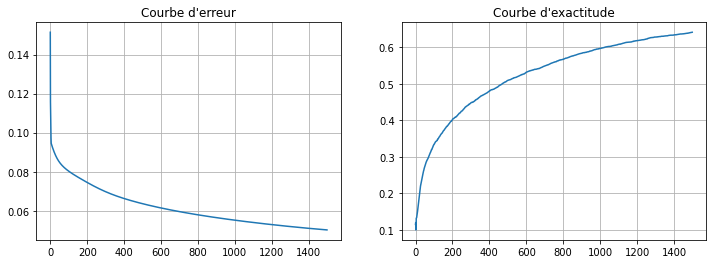

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax0 = axs[0]
ax0.plot(losses)
ax0.grid()
ax0.set_title("Courbe d'erreur")

ax1 = axs[1]
ax1.plot(accs)
ax1.grid()
ax1.set_title("Courbe d'exactitude")

plt.savefig("apprentissage3.jpg")

In [20]:
# sauvegarde du model
pickle.dump( model, open( "demo.p", "wb" ) )

In [38]:
pickle.dump( losses, open( "losses.p", "wb" ) )
pickle.dump( accs, open( "accs.p", "wb" ) )

# Test sur le model

In [8]:
model = pickle.load( open( "demo.p", "rb" ) )

In [86]:
# L'accuracy n'est pas le meme selon les nombres
for i in range(10):
    indexer = (Y_test == i)
    acc = model.compute_accuracy(x_test[indexer], y_test[indexer])
    print(f"For {i} accuracy is {round(acc * 100, 2)}")

For 0 accuracy is 76.02
For 1 accuracy is 90.31
For 2 accuracy is 54.55
For 3 accuracy is 67.82
For 4 accuracy is 64.66
For 5 accuracy is 42.71
For 6 accuracy is 71.71
For 7 accuracy is 67.41
For 8 accuracy is 44.46
For 9 accuracy is 56.0


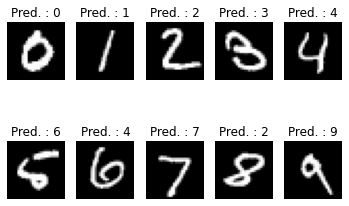

In [95]:
fig, axs = plt.subplots(2, 5)
plt.axis('off')
liste = [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
for i in range(2):
    for j in range(5):
        n = i*5 + j
        ax = axs[i, j]
        ax.imshow(X_test[liste[n]], cmap="gray")
        ax.axis('off')
        ax.set_title(f"Pred. : {model.predict([x_test[liste[n]]]).argmax()}")
plt.savefig("Prediction.jpg")

In [88]:
model.predict(x_test[liste[1]]).argmax()

0

In [91]:
model.predict([x_test[liste[1]]])

array([[0.00082465, 0.34589804, 0.04709299, 0.00769055, 0.11681517,
        0.02451989, 0.17327472, 0.02718476, 0.14917841, 0.10752082]])

In [79]:
X_test[liste[n]]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [60]:
help(plt.subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs)
    Add a subplot to the current figure.
    
    Wrapper of `.Figure.add_subplot` with a difference in behavior
    explained in the notes section.
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(**kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
        The position of the subplot described by one of
    
        - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
          *index* position on a grid with *nrows* rows and *ncols* columns.
          *index* starts at 1 in the upper left corner and increases to the
          right. *index* can also be a two-tuple specifying the (*first*,
          *last*) indices (1-based, and including *last*) of the subplot, e.g.,
          ``fig.add_subplot(3, 1, (1, 2))`` makes a subplot t

In [ ]:
[3, 2, 1, 18, 4, 8, 11, 0, 61, 7]

In [43]:
Y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [49]:
for i, x in enumerate(Y_test[:100]):
    if x == 8:
        print(i)

61
84


In [90]:
model.predict([x_test[2]]).argmax()

1

In [27]:
model.predict([x_test[1]])

array([[0.11776384, 0.03745747, 0.13988358, 0.17766919, 0.13496387,
        0.01081449, 0.28744254, 0.04125383, 0.02985277, 0.02289842]])